In [6]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Paths to CSV file and images folder
csv_file = '/content/drive/MyDrive/Soft_Tissue-20250116T155622Z-001/Soft_Tissue/Final - Facial Profile Types.csv'
image_folder = '/content/drive/MyDrive/Soft_Tissue-20250116T155622Z-001/Soft_Tissue/cepha400'

# Load CSV
df = pd.read_csv(csv_file)

# Remove "Concave - Convex" class
df = df[df['type'] != 'Concave - Convex']

# Function to get zero-padded image filenames
def get_image_path(image_id, folder):
    image_filename = f"{str(image_id).zfill(3)}.jpg"
    return os.path.join(folder, image_filename), image_filename  # Return path and filename

# Prepare dataset: (Image, Tabular Features, Label, Image Name)
combined_data = []
for index, row in df.iterrows():
    image_id = row['data']
    label = row['type']
    upper_lip = row['upper_lip']
    lower_lip = row['lower_lip']

    # Load image with correct path
    image_path, image_filename = get_image_path(image_id, image_folder)
    try:
        img = load_img(image_path, target_size=(224, 224))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        combined_data.append((img_array, [upper_lip, lower_lip], label, image_filename))
    except FileNotFoundError:
        print(f"Image {image_path} not found.")
        continue

# Convert tabular features to One-Hot Encoding
tabular_features = np.array([sample[1] for sample in combined_data])
encoder = OneHotEncoder(sparse_output=False)
tabular_features_encoded = encoder.fit_transform(tabular_features)

# Encode the labels
labels = [sample[2] for sample in combined_data]
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_one_hot = to_categorical(labels_encoded)

# Extract images and image names
images = np.array([sample[0] for sample in combined_data])
image_filenames = np.array([sample[3] for sample in combined_data])  # Image filenames

# Create tuples with all mapped features
data_tuples = list(zip(images, tabular_features_encoded, labels_one_hot, image_filenames))

# Split dataset into Train (70%), Validation (15%), Test (15%)
train_data, temp_data = train_test_split(data_tuples, test_size=0.3, stratify=labels_encoded, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=[np.argmax(sample[2]) for sample in temp_data], random_state=42)

# Unpack Train, Validation, Test sets correctly
X_train_img = np.array([sample[0] for sample in train_data])
X_train_tabular = np.array([sample[1] for sample in train_data])
y_train = np.array([sample[2] for sample in train_data])
train_image_filenames = np.array([sample[3] for sample in train_data])  # Keep Image Names

X_val_img = np.array([sample[0] for sample in val_data])
X_val_tabular = np.array([sample[1] for sample in val_data])
y_val = np.array([sample[2] for sample in val_data])
val_image_filenames = np.array([sample[3] for sample in val_data])  # Keep Image Names

X_test_img = np.array([sample[0] for sample in test_data])
X_test_tabular = np.array([sample[1] for sample in test_data])
y_test = np.array([sample[2] for sample in test_data])
test_image_filenames = np.array([sample[3] for sample in test_data])  # Keep Image Names

# Print check: Ensure correct mapping after split
print("✅ Train Set Sample:", train_image_filenames[0], X_train_tabular[0], y_train[0])
print("✅ Validation Set Sample:", val_image_filenames[0], X_val_tabular[0], y_val[0])
print("✅ Test Set Sample:", test_image_filenames[0], X_test_tabular[0], y_test[0])


✅ Train Set Sample: 020.jpg [1. 0. 0. 0. 1. 0.] [1. 0. 0. 0.]
✅ Validation Set Sample: 058.jpg [1. 0. 0. 0. 1. 0.] [1. 0. 0. 0.]
✅ Test Set Sample: 366.jpg [1. 0. 0. 0. 1. 0.] [1. 0. 0. 0.]



🔍 Visualizing Train Dataset Samples:


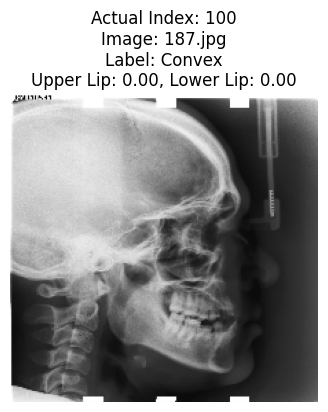

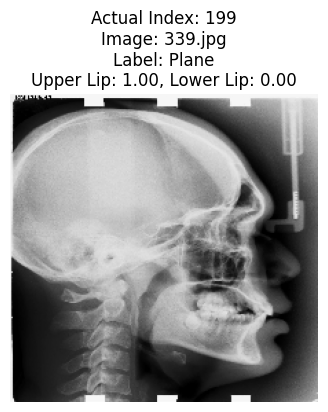

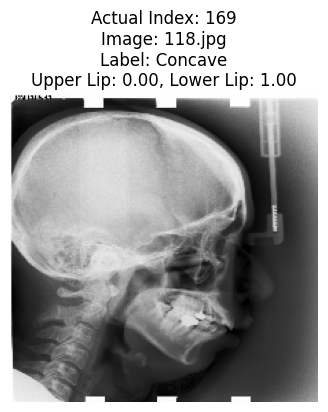

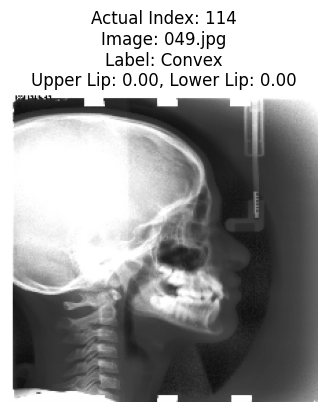

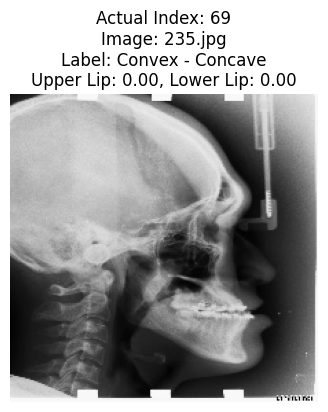


🔍 Visualizing Validation Dataset Samples:


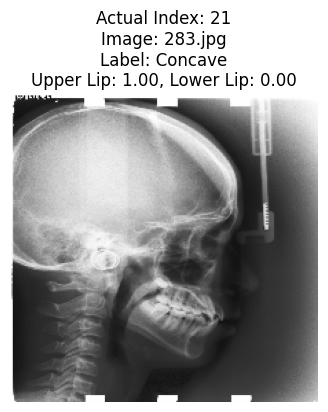

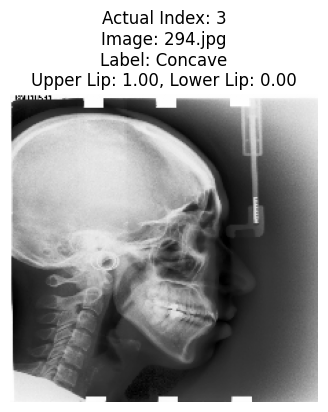

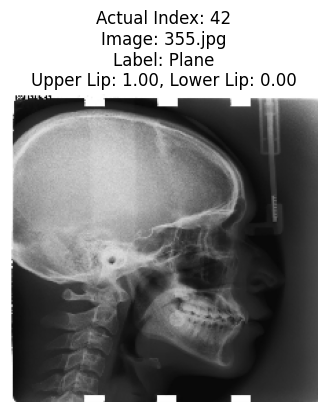

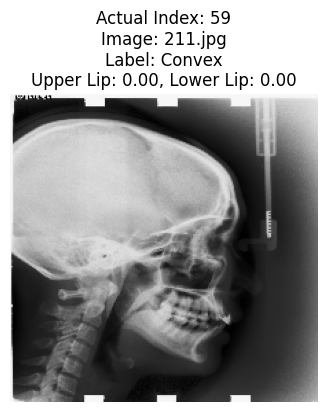

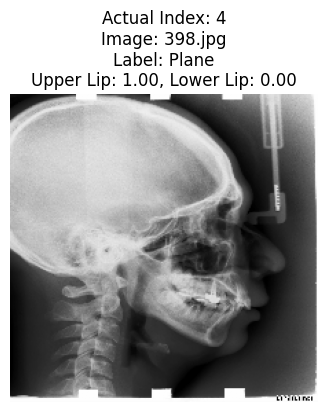


🔍 Visualizing Test Dataset Samples:


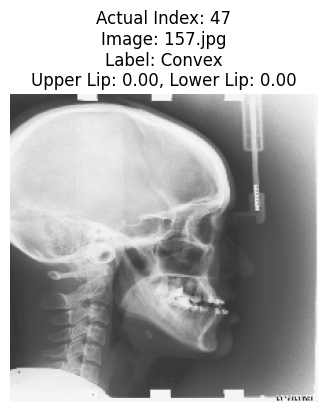

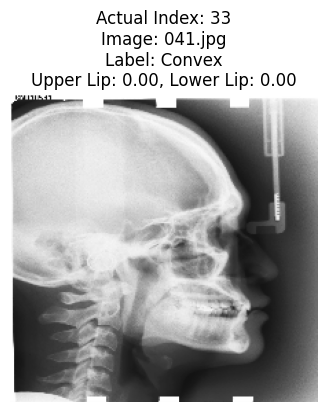

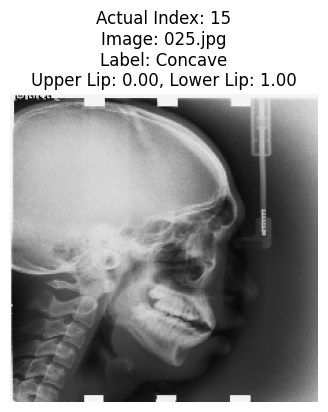

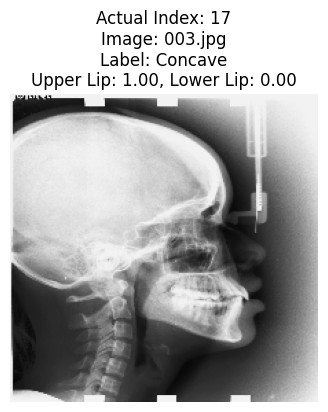

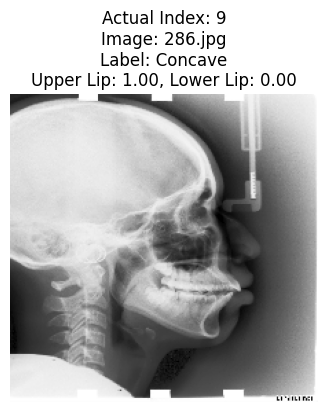

In [7]:
import matplotlib.pyplot as plt
import random

# Define label mapping
label_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}

# Function to visualize images along with their tabular data and labels
def visualize_sample(dataset, dataset_name, indices):
    print(f"\n🔍 Visualizing {dataset_name} Dataset Samples:")

    for i in indices:
        actual_index = i  # Get the actual index in dataset
        img = dataset[i][0]  # Get image
        upper_lip = dataset[i][1][0]  # First tabular feature
        lower_lip = dataset[i][1][1]  # Second tabular feature
        label_index = np.argmax(dataset[i][2])  # Get label index
        label_text = label_mapping[label_index]  # Convert index to text label
        img_filename = dataset[i][3]  # Get image filename

        # Display Image
        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Actual Index: {actual_index}\nImage: {img_filename}\nLabel: {label_text}\nUpper Lip: {upper_lip:.2f}, Lower Lip: {lower_lip:.2f}")
        plt.show()

# Pick 5 random indices from Train, Validation, and Test sets
train_indices = random.sample(range(len(train_data)), 5)
val_indices = random.sample(range(len(val_data)), 5)
test_indices = random.sample(range(len(test_data)), 5)

# Run visualization
visualize_sample(train_data, "Train", train_indices)
visualize_sample(val_data, "Validation", val_indices)
visualize_sample(test_data, "Test", test_indices)


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Dropout
import tensorflow as tf

# Data augmentation for images only (keeping tabular features & labels consistent)
datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

augmented_images, augmented_tabular, augmented_labels = [], [], []

for i in range(len(X_train_img)):
    img = X_train_img[i].reshape((1,) + X_train_img[i].shape)  # Reshape for generator
    tabular_features = X_train_tabular[i]
    label = y_train[i]

    aug_iter = datagen.flow(img, batch_size=1)
    for _ in range(5):  # Generate 5 augmented images per original image
        aug_img = next(aug_iter)[0]  # Get augmented image
        augmented_images.append(aug_img)
        augmented_tabular.append(tabular_features)  # Keep tabular data unchanged
        augmented_labels.append(label)  # Keep label unchanged

# Combine original and augmented data
X_train_img = np.vstack([X_train_img, np.array(augmented_images)])
y_train = np.vstack([y_train, np.array(augmented_labels)])
X_train_tabular = np.vstack([X_train_tabular, np.array(augmented_tabular)])

print("\nData augmentation completed for training set.")
print(f"New training set size: {len(X_train_img)} images.")

# Build MobileNetV2 multimodal model
mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in mobilenetv2.layers:
    layer.trainable = False

x_img = Flatten()(mobilenetv2.output)

# Tabular model
input_tabular = Input(shape=(X_train_tabular.shape[1],), name="tabular_input")
x_tabular = Dense(128, activation='relu')(input_tabular)

# Combine image and tabular features
combined = Concatenate()([x_img, x_tabular])
x = Dense(256, activation='relu')(combined)
x = Dropout(0.5)(x)
output = Dense(y_train.shape[1], activation='softmax')(x)

model = Model(inputs=[mobilenetv2.input, input_tabular], outputs=output)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    [X_train_img, X_train_tabular], y_train,
    validation_data=([X_val_img, X_val_tabular], y_val),
    epochs=70,
    batch_size=32,
    verbose=1
)

# Evaluate the model
val_loss, val_accuracy = model.evaluate([X_val_img, X_val_tabular], y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Predict on the test set
y_pred = model.predict([X_test_img, X_test_tabular])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)



Data augmentation completed for training set.
New training set size: 1674 images.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/70
53/53 ━━━━━━━━━━━━━━━━━━━━ 27s 272ms/step - accuracy: 0.4351 - loss: 10.8365 - val_accuracy: 0.6000 - val_loss: 1.0569
Epoch 2/70
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5834 - loss: 1.1378 - val_accuracy: 0.6000 - val_loss: 1.0280
Epoch 3/70
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.5728 - loss: 1.0863 - val_accuracy: 0.6167 - val_loss: 1.0154
Epoch 4/70
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.5932 - loss: 0.9430 - val_accuracy: 0.5667 - val_loss: 1.0115
Epoch 5/70
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6258 - loss: 0.9189 - val_accuracy: 0.6000 - val_loss: 1.0244
Epoch 6/70
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6247 - loss: 0.8260 - val_accuracy: 0.6000 - val_loss: 1.0212
Epoch 7/70
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.6570 - loss: 0.7356 - val_accuracy: 0.

In [10]:
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Generate the classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_, digits=4)

# Compute overall accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)

# Compute overall macro and weighted F1-score
macro_f1 = f1_score(y_true_classes, y_pred_classes, average='macro')
weighted_f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

# Print the classification report
print("\nClassification Report:\n", report)
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Weighted F1 Score: {weighted_f1:.4f}")



Classification Report:
                   precision    recall  f1-score   support

         Concave     0.8409    1.0000    0.9136        37
          Convex     0.7692    0.9091    0.8333        11
Convex - Concave     0.0000    0.0000    0.0000         3
           Plane     0.6667    0.2222    0.3333         9

        accuracy                         0.8167        60
       macro avg     0.5692    0.5328    0.5201        60
    weighted avg     0.7596    0.8167    0.7662        60

Overall Accuracy: 0.8167
Macro F1 Score: 0.5201
Weighted F1 Score: 0.7662


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


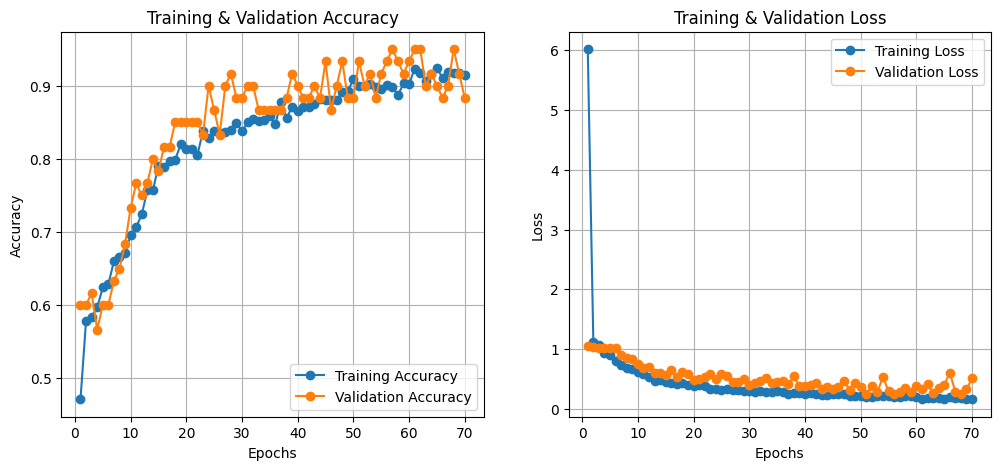

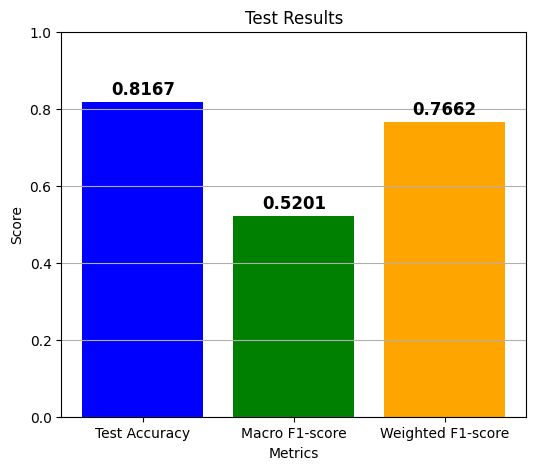

In [11]:
import matplotlib.pyplot as plt

# Plot Training & Validation Accuracy and Loss
def plot_training_history(history):
    epochs = range(1, len(history.history['loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()
    plt.grid()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss', marker='o')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()
    plt.grid()

    plt.show()

# Call the function to plot training history
plot_training_history(history)

# Plot Test Metrics (Accuracy & F1-score)
def plot_test_results(accuracy, macro_f1, weighted_f1):
    metrics = ['Test Accuracy', 'Macro F1-score', 'Weighted F1-score']
    values = [accuracy, macro_f1, weighted_f1]

    plt.figure(figsize=(6, 5))
    plt.bar(metrics, values, color=['blue', 'green', 'orange'])
    plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
    plt.xlabel("Metrics")
    plt.ylabel("Score")
    plt.title("Test Results")
    plt.grid(axis='y')

    for i, v in enumerate(values):
        plt.text(i, v + 0.02, f"{v:.4f}", ha='center', fontsize=12, fontweight='bold')

    plt.show()

# Call the function to plot test results
plot_test_results(accuracy, macro_f1, weighted_f1)


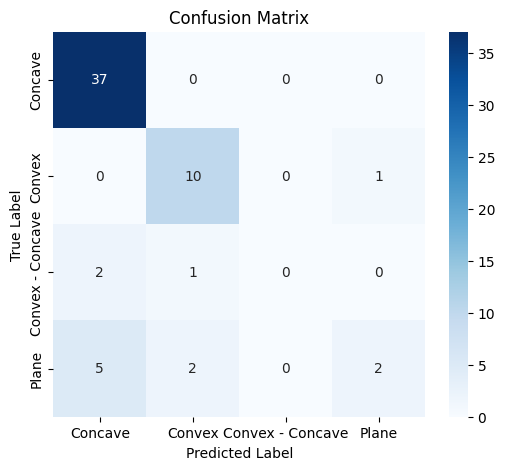

In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


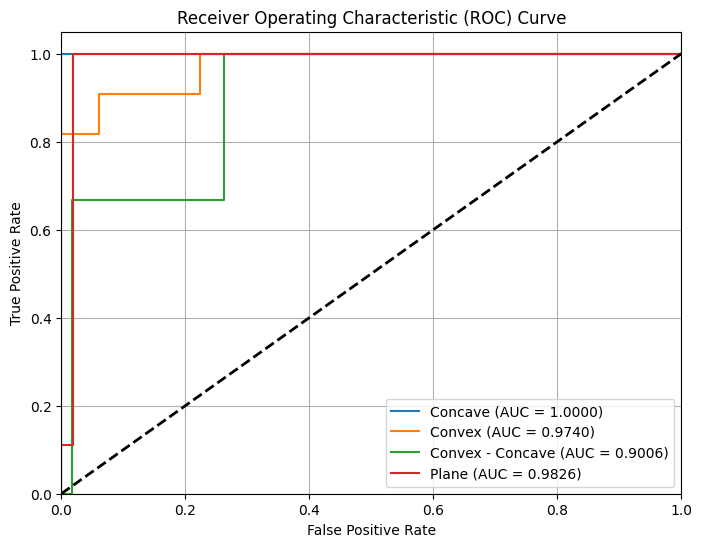

In [13]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC for each class
plt.figure(figsize=(8, 6))
for i in range(y_test.shape[1]):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label_encoder.classes_[i]} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()


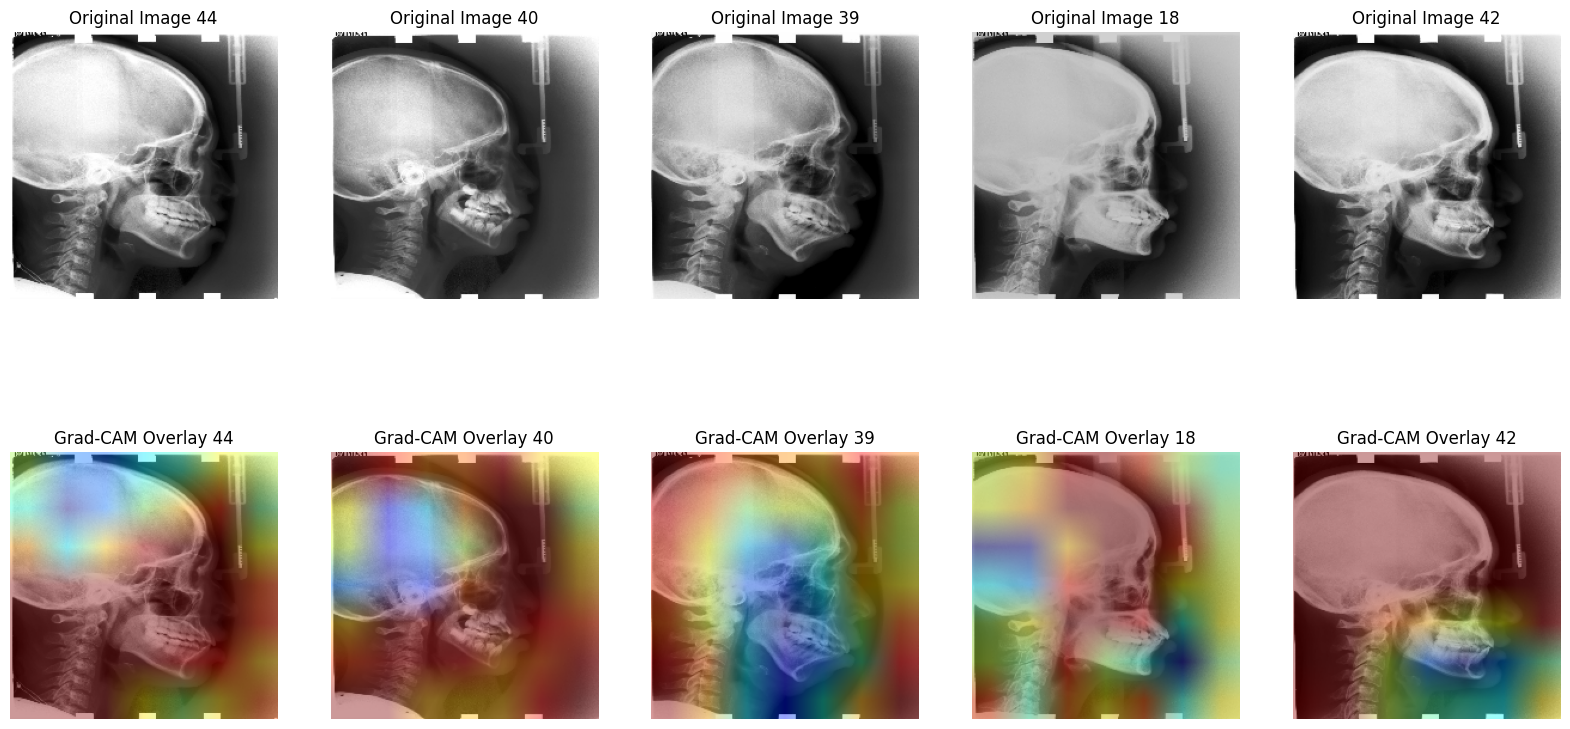

In [21]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import random

# Function to generate Grad-CAM heatmap
def generate_gradcam(model, image_array, tabular_data, class_index):
    grad_model = tf.keras.models.Model(
        inputs=[model.input[0], model.input[1]],  # Using both image and tabular inputs
        outputs=[model.get_layer("Conv_1").output, model.output]  # Extracting convolutional layer outputs
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model([tf.convert_to_tensor(image_array), tf.convert_to_tensor(tabular_data)])
        loss = predictions[:, class_index]  # Loss based on the predicted class

    grads = tape.gradient(loss, conv_outputs)  # Calculate gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # Pool the gradients

    conv_outputs = conv_outputs.numpy()[0]
    pooled_grads = pooled_grads.numpy()

    # Multiply gradients with convolutional outputs to get weighted feature map
    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)  # Average over all channels
    heatmap = np.maximum(heatmap, 0)  # ReLU (Remove negative values)
    heatmap /= np.max(heatmap)  # Normalize heatmap
    return heatmap

# Select multiple random indices for test samples
num_samples = 5  # Number of images to display
random_indices = random.sample(range(len(X_test_img)), num_samples)

# Plot results for multiple random test samples
plt.figure(figsize=(20, 10))

for idx, sample_idx in enumerate(random_indices):
    # Prepare the sample image and tabular data
    sample_img_array = np.expand_dims(X_test_img[sample_idx], axis=0)  # Add batch dimension
    sample_tabular_array = np.expand_dims(X_test_tabular[sample_idx], axis=0)  # Add batch dimension
    sample_class_index = np.argmax(y_test[sample_idx])  # Get class index of the sample

    # Generate Grad-CAM heatmap
    heatmap = generate_gradcam(model, sample_img_array, sample_tabular_array, sample_class_index)

    # Convert heatmap to uint8
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Apply color map for better visibility

    # Convert the original image to uint8 for visualization
    sample_img_uint8 = (sample_img_array[0] * 255).astype(np.uint8)

    # Resize heatmap to match the size of the original image
    if heatmap.shape[:2] != sample_img_uint8.shape[:2]:
        heatmap = cv2.resize(heatmap, (sample_img_uint8.shape[1], sample_img_uint8.shape[0]))

    # Overlay Heatmap on Original Image
    superimposed_img = cv2.addWeighted(sample_img_uint8, 0.6, heatmap, 0.4, 0)

    # Display Original Image and Grad-CAM Overlay
    plt.subplot(2, num_samples, idx + 1)
    plt.imshow(sample_img_uint8)
    plt.title(f"Original Image {sample_idx}")
    plt.axis("off")

    plt.subplot(2, num_samples, idx + 1 + num_samples)
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM Overlay {sample_idx}")
    plt.axis("off")

plt.show()
